# **import**

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# **data**

In [2]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

check em out

In [3]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



see examples(just copy the code)

Sample horse image:


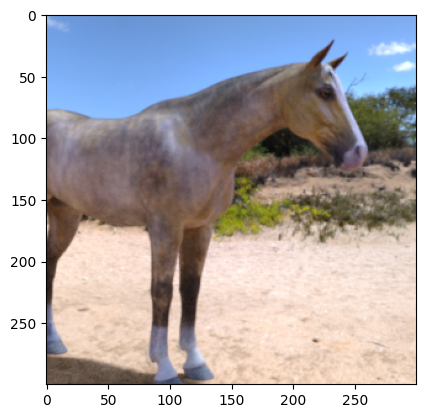


Sample human image:


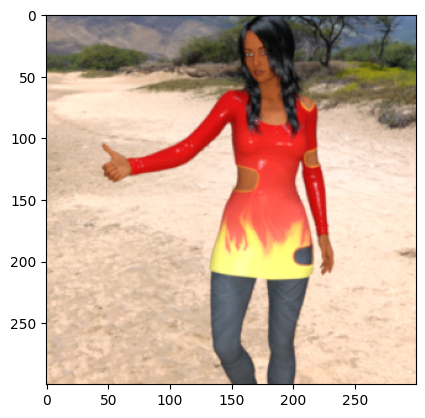

In [4]:
# grader-required-cell

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

## Training and Validation Generators

In [5]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=8,
                                                                class_mode="binary",
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [16]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Transfer learning

In [6]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-04 10:23:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 142.250.159.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   136MB/s    in 0.6s    

2023-10-04 10:23:54 (136 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = local_weights_file)

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [9]:
pre_trained_model = create_pre_trained_model(local_weights_file)
print(pre_trained_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

test them to not be trainable

In [10]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


# **Pipelining the pre-trained**

In [11]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [12]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


# **model**

In [13]:
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  inputs = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  conv = layers.Dense(1024, activation='relu')(inputs)
  # Add a dropout rate of 0.2
  drop = layers.Dropout(0.2)(conv)
  # Add a final sigmoid layer for classification
  our_model = layers.Dense  (1, activation='sigmoid')(drop)

  # Create the complete model by using the Model class
  full_model = Model(pre_trained_model.input, our_model)

  full_model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
  return full_model


In [14]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


# **callback**

In [21]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True


# **train**

In [22]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 15,
                    verbose = 1,  #is either 0, 1, 2
                    callbacks=callbacks)

Epoch 1/15
65/65 [==============================] - 120s 2s/step - loss: 0.0263 - accuracy: 0.9873 - val_loss: 8.0319e-04 - val_accuracy: 1.0000
Epoch 2/15
65/65 [==============================] - 120s 2s/step - loss: 0.0097 - accuracy: 0.9961 - val_loss: 0.0072 - val_accuracy: 0.9961
Epoch 3/15
65/65 [==============================] - 120s 2s/step - loss: 0.0113 - accuracy: 0.9951 - val_loss: 0.0051 - val_accuracy: 0.9961
Epoch 4/15
65/65 [==============================] - 127s 2s/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0053 - val_accuracy: 0.9961
Epoch 5/15
65/65 [==============================] - 120s 2s/step - loss: 0.0071 - accuracy: 0.9961 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/15
65/65 [==============================] - 118s 2s/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/15
65/65 [==============================] - 114s 2s/step - loss: 0.0169 - accuracy: 0.9922 - val_loss: 0.0280 - val_accuracy: 0.9922
Epoch 8/1

# **chart**

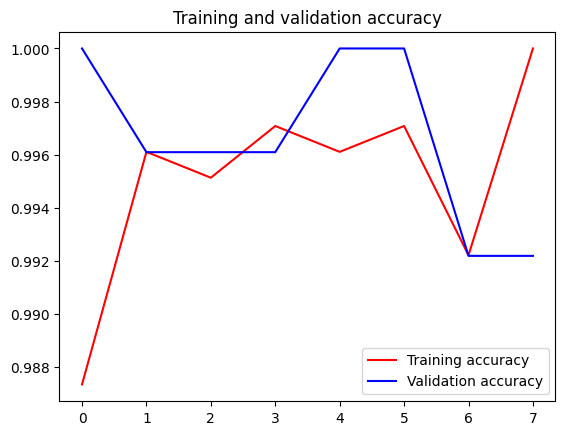

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# **download**

In [25]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>